In [20]:
import logging
import pandas as pd 
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
sns.set(style="whitegrid")

from dft_descriptors import prepocessing as pp
from dft_descriptors import featurisation as ft

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import xgboost as xgb

logging.basicConfig(level=logging.INFO)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [21]:
df = pd.read_csv("data_csv/Data_test11082021.csv", sep = ',')
# Removing 
vc = df.DOI.value_counts()
doi_above_10 = np.array(vc[vc > 20].index)

# remove doi with less than 20 data_points
indexes = []
for i, row in df.iterrows():
    if row["DOI"] not in doi_above_10:
        indexes.append(i)
        
df = df.drop(indexes)
df = df.reset_index(drop=True)

# preprocess dataframe
df2 = pp.preprocess(df)

In [22]:
df_data = ft.dft_ft(df2, data_path="data_csv/")

NoLigand


In [34]:
def duplicates(X, round=None) -> list:
    """Drop duplicate columns in dataframe

    :param X: input dataframe
    :type X: pandas.core.frame.DataFrame
    :param round: decimal point used for rounding. If set the dataframe is scaled with MinMaxScaler \
    and rounded to the given precision, afterward duplicates are removed. This allows to drop duplicates avoiding \
    floating point precision issues
    :type round: int
    :return: list of columns that are duplicates
    """

    X_ = X.copy()
    if round is not None:
        scaler = MinMaxScaler()
        X_ = pd.DataFrame(scaler.fit_transform(X_),
                          columns=X_.columns,
                          index=X_.index)
        X_ = X_.round(round)
    return X_.columns[X_.T.duplicated()].tolist()


def correlated(X, threshold=0.95) -> list:
    """Decorrelate dataframe by finding which columns shall \
    be removed to achieve correlation level below threshold

    :param X: input dataframe
    :type X: pandas.core.frame.DataFrame
    :param threshold: maximum correlation allowed in the frame X
    :type threshold: float
    :return: list of columns to prune in order to achieve desired decorrelation level
    """

    X_ = X.copy()
    N = X_.shape[1]
    corr = X_.corr().abs()

    to_drop = set()
    for i in range(N - 1):
        for j in range(i + 1, N):
            if corr.iloc[i][j] > threshold and i not in to_drop:
                to_drop.add(j)
    return [X_.columns[i] for i in to_drop]

def setup_df(df):
    for col in df_data.columns:
        df[col] = df[col].astype(float, errors = 'raise')
    
    df=df.select_dtypes(exclude='object')

    scaler = MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
    
    X, y = df.loc[:, df.columns != 'yield'], df['yield']
    print (f"Number of features: {X.shape[1]}, number of samples: {X.shape[0]}")
    
    zero_std = X.std()[X.std() == 0].index
    display(f"Zero std columns: {len(zero_std)}")
    X = X[X.columns.difference(zero_std)]
    
    dupes = duplicates(X, round=3)
    display(f"Duplicate columns: {len(dupes)}")
    X = X[X.columns.difference(dupes)]
    
    high_corr = correlated(X, threshold=0.99)
    display(f"Correlated features: {len(high_corr)}")
    X = X[X.columns.difference(high_corr)]
    
    print (f"Number of features: {X.shape[1]}, number of samples: {X.shape[0]}")
    
    # Chemistry world loves t-SNE plots, so let's make it
    tX = TSNE().fit_transform(X)
    sns.scatterplot(x=tX[:,0], y=tX[:, 1], alpha=0.8)
    plt.show()
    
    p = PCA()
    X_pca = p.fit_transform(X)
    explained_var = pd.Series(p.explained_variance_ratio_.cumsum())
    explained_var[explained_var < 1].plot(grid=True)
    plt.show()
    
    print ("Choosing n_pc = 100")
    n_pc = 100
    X_pca = X_pca[:, :n_pc]
    
    # let's redo the t-SNE plot and see whether things changed
    tX_pca = TSNE().fit_transform(X_pca)
    sns.scatterplot(x=tX_pca[:,0], y=tX_pca[:, 1], alpha=0.8)
    plt.show()
    
    return X, y
    

Number of features: 358, number of samples: 1603


'Zero std columns: 0'

'Duplicate columns: 3'

'Correlated features: 17'

Number of features: 338, number of samples: 1603


/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


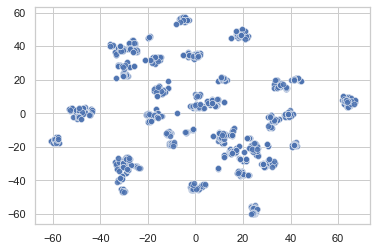

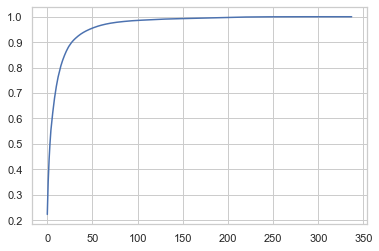

Choosing n_pc = 100


/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


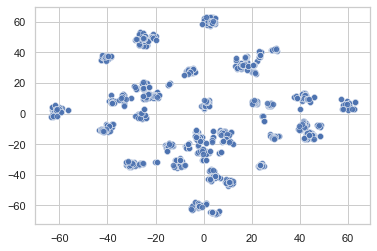

In [35]:
X, y = setup_df(df_data)

# Permutation importance

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

In [44]:
X_reg = X.copy()
X_reg = pd.DataFrame(X_reg, index=df_data.index)
i = 1
X_train, X_test, y_train, y_test = train_test_split(X_reg, y, test_size=0.1, random_state=i)
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [45]:
keep_feautres = 20
result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()[-keep_feautres:]

In [47]:
sorted_idx

array([294, 278, 179, 199, 168, 204, 315,  23, 213, 295, 318,  77, 273,
        60, 169, 272,  71, 229, 298,  13])

In [ ]:
fig, ax = plt.subplots()

ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_reg.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()